In [198]:


import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm


/tmp/ipykernel_230513/2722164056.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [201]:
np.log2(np.exp(1)), np.exp(1)



(1.4426950408889634, 2.718281828459045)

In [156]:

import torch
print("Using torch", torch.__version__)


Using torch 1.10.1+cpu


In [140]:

torch.manual_seed(42)



# Defining variables and taking gradients

In [194]:


x = torch.arange(start=0, end=3, step=1, dtype=torch.float32, requires_grad=True)
x

tensor([0., 1., 2.], requires_grad=True)

In [195]:
x_fn = torch.sigmoid(x)

x_fn

tensor([0.5000, 0.7311, 0.8808], grad_fn=<SigmoidBackward0>)

In [196]:
x_fn.sum().backward()

x_fn

tensor([0.5000, 0.7311, 0.8808], grad_fn=<SigmoidBackward0>)

In [197]:
x_fn.grad


In [144]:


y = torch.mean(torch.pow(x+2, 2) + 3)
y



tensor(12.6667, grad_fn=<MeanBackward0>)

In [146]:

y.backward()




In [147]:

x.grad


tensor([1.3333, 2.0000, 2.6667])

# Simple classification

In [105]:

import torch.nn as nn


In [106]:
import torch.nn.functional as F

In [107]:


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)



Device cpu


In [108]:
class SimpleClassifier(nn.Module):
    
    def __init__(self, num_inputs, num_hiddens, num_outputs):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.num_outputs = num_outputs

        self.linear1 = nn.Linear(
            in_features=self.num_inputs,
            out_features=self.num_hiddens, 
        )
        
        self.act_fn = nn.Tanh()
        
        self.linear2 = nn.Linear(
            in_features=num_hiddens, 
            out_features=self.num_outputs, 
            
        )
        
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
        
        
        

In [109]:


model = SimpleClassifier(num_inputs=2, num_hiddens=4, num_outputs=1)

print(model)



SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [110]:

for name, param in model.named_parameters():
    print(f"Parameter {name}, Shape: {param.shape}")
    
    
    
    

Parameter linear1.weight, Shape: torch.Size([4, 2])
Parameter linear1.bias, Shape: torch.Size([4])
Parameter linear2.weight, Shape: torch.Size([1, 4])
Parameter linear2.bias, Shape: torch.Size([1])


# Data

In [111]:


import torch.utils.data as data



In [112]:


class XORDataset(data.Dataset):
    """
        size := num data points,
        std := Gaussian noise standard deviation
        
    """
    def __init__(self, size, std=0.1):
    
        super().__init__()
        self.size = size
        self.std = std 
        self.generate_continuous_xor()
        
    def generate_continuous_xor(self, ):
        
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        

        data += self.std * torch.randn(data.shape)
        
        self.data = data
        self.label = label
        
    def __len__(self, ):
        return self.size
    
    def __getitem__(self, idx, ):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return (data_point, data_label)
    
    


In [113]:

dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])



Size of dataset: 200
Data point 0: (tensor([0.8675, 0.9484]), tensor(0))


In [148]:


def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    

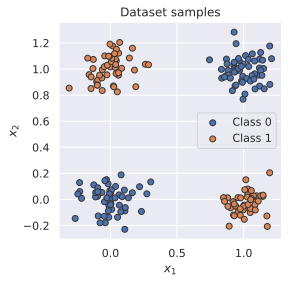

In [149]:

visualize_samples(dataset.data, dataset.label)
plt.show()



In [116]:

data_loader = data.DataLoader(dataset=dataset, batch_size=8, shuffle=True)

data_inputs, data_labels = next(iter(data_loader))

print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)


Data inputs torch.Size([8, 2]) 
 tensor([[ 1.1953,  0.2049],
        [-0.1459,  0.8506],
        [-0.1253,  0.1119],
        [ 0.0531, -0.1361],
        [ 0.1345,  0.0127],
        [-0.1449,  0.9395],
        [ 1.0506,  0.9082],
        [ 1.0080,  0.0745]])
Data labels torch.Size([8]) 
 tensor([1, 1, 0, 0, 0, 1, 0, 1])


In [133]:

train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)



In [117]:


loss_bce = nn.BCEWithLogitsLoss()



In [118]:

opt_sgd = torch.optim.SGD(model.parameters(), lr=1e-1)


In [119]:

# Push model to device. Has to be only done once
model.to(device)



SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [120]:


def train_model(model, optimizer, loss_module, data_loader, n_epochs=100):
    
    # Set the model to trian mode
    model.train()
    
    # Training loop
    for epoch in tqdm(range(n_epochs)):
        for data_inputs, data_labels in data_loader:
            
            # Step1: load data
            data_inputs = data_inputs.to(data_inputs)
            data_labels = data_labels.to(data_labels)
            
            # Step2: predict
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            
            # Step3: compute loss
            loss = loss_module(preds, data_labels.float())
            
            # Step4: perform backpropagation:
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            
            # Perform backpropagation
            loss.backward()
            
            # Step5: update the weights
            optimizer.step()


            
    
    
    

In [121]:


train_model(model=model, optimizer=opt_sgd, loss_module=loss_bce, data_loader=data_loader,)




  0%|          | 0/100 [00:00<?, ?it/s]

In [122]:

state_dict = model.state_dict()

print(state_dict)


OrderedDict([('linear1.weight', tensor([[ 2.1096,  2.0960],
        [-3.4196,  2.6382],
        [-0.4121, -0.3184],
        [-2.4241,  3.3502]])), ('linear1.bias', tensor([-0.2937, -1.0639,  0.8211,  1.0664])), ('linear2.weight', tensor([[ 3.1998,  4.6526,  0.8506, -4.6537]])), ('linear2.bias', tensor([1.3395]))])


In [123]:


# torch.save(object, filename). For the filename, any extension can be used
# torch.save(state_dict, "our_model.tar")


# Load state dict from the disk (make sure it is the same name as above)
# state_dict = torch.load("our_model.tar")



new_model = SimpleClassifer(num_inputs=2, num_hiddens=4, num_outputs=1)

new_model.load_state_dict(state_dict)

new_model


SimpleClassifer(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [124]:

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())



Original model
 OrderedDict([('linear1.weight', tensor([[ 2.1096,  2.0960],
        [-3.4196,  2.6382],
        [-0.4121, -0.3184],
        [-2.4241,  3.3502]])), ('linear1.bias', tensor([-0.2937, -1.0639,  0.8211,  1.0664])), ('linear2.weight', tensor([[ 3.1998,  4.6526,  0.8506, -4.6537]])), ('linear2.bias', tensor([1.3395]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[ 2.1096,  2.0960],
        [-3.4196,  2.6382],
        [-0.4121, -0.3184],
        [-2.4241,  3.3502]])), ('linear1.bias', tensor([-0.2937, -1.0639,  0.8211,  1.0664])), ('linear2.weight', tensor([[ 3.1998,  4.6526,  0.8506, -4.6537]])), ('linear2.bias', tensor([1.3395]))])


## Evaluate 



In [125]:


test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)



In [150]:
def eval_model(model, data_loader):
    
    model.eval()  # set to eval model
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)  # convert logits to probs
            
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    

In [151]:

eval_model(model=model, data_loader=test_data_loader)



Accuracy of the model: 100.00%


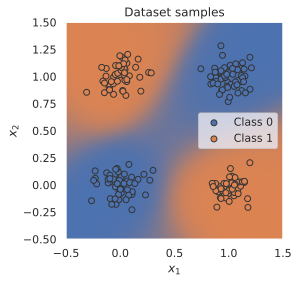

In [153]:


@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()





In [154]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [130]:


def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='runs/our_experiment'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False

    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()

        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)

        # Visualize prediction and add figure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)

    writer.close()
    
    

In [135]:


model = SimpleClassifier(num_inputs=2, num_hiddens=4, num_outputs=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_bce, val_dataset=dataset)



2022-03-11 20:21:32.028105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-11 20:21:32.028179: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


  0%|          | 0/100 [00:00<?, ?it/s]

In [137]:

%tensorboard --logdir runs/our_experiment


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.